# CUNEF MUCD 2021/2022  
## Machine Learning
## Análisis de Siniestralidad de Automóviles

### Autores:
- Andrés Mahía Morado
- Antonio Tello Gómez


# Ingeniería de variables

La ingeniería de variables hace referencia al proceso de transformación de los datos brutos en variables útiles que puedan ser utilizadas en nuestros modelos. Es un parte clave del proceso ya que la calidad de nuestro modelo va a depender de la calidad de nuestras _features_.  
Parte de este trabajo ya lo hemos realizado en el EDA siendo el ejemplo más claro la creación de una nueva variable _vehicle_age_ a partir de otras dos. En este apartado continuaremos esta tarea dejando el conjunto de datos listo para su introducción en los modelos. Hemos optado por realizar el proceso de forma manual pero hubiera sido más eficiente emplear pipelines que aplicaran una gran parte de las transformaciones en unas pocas líneas de código.


![FE](https://miro.medium.com/max/1276/1*8nMiAqNbGlTgevVaWbF60g.png)

In [30]:
#Liberías
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from imblearn.over_sampling import SMOTE
from category_encoders import TargetEncoder
from sklearn.preprocessing import OneHotEncoder
from collections import Counter
from sklearn import metrics
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer, MissingIndicator
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
import pickle
%load_ext autotime

import warnings
warnings.filterwarnings('ignore')

from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, \
                            silhouette_score, recall_score, precision_score, make_scorer, \
                            roc_auc_score, f1_score, precision_recall_curve

time: 0 ns (started: 2021-12-18 18:22:22 +01:00)


In [3]:
# Lecutra de datos preprocesados
df = pd.read_parquet('../data/full_data_initial.parquet')

## Filtrado de los datos

Como explicamos en la introducción los datos presentan un problema y es que cada fila representa una persona y nuestra variable objetivo es a nivel de accidente.  
Con la finalidad de resolver este problema y acercar lo máximo posible los datos al problema de negocio hemos decidido filtrar el conjunto de datos para quedarnos solo con los conductores de cada vehículo eliminando al resto de pasajeros. De esta forma, no solo suprimimos duplicidades que generarían un problema de overfitting en nuestro modelo, sino que además acercamos nuestra información a un caso más realista en el que solo tenemos información del asegurado. Por otro lado, también hemos dejado los registros de peatones para poder diferenciar los arrollamientos.


In [4]:
df = df.loc[(df['passenger_role'] == "11") | (df['passenger_role'] == "99")]
df = df.drop('passenger_role', axis = 1)

## Transformaciones pre-split

### Valores Missing y outliers


In [5]:
# Análisis Nulos
nulos_col = pd.merge(df.isnull().sum().sort_values().to_frame('missing_value').reset_index(),
         df.dtypes.to_frame('feature_type').reset_index(),
         on = 'index',
         how = 'inner')
nulos_col['columns_percentage'] = nulos_col['missing_value']/df.shape[0]
nulos_col.sort_values(['missing_value', 'feature_type', 'columns_percentage'], ascending=False)

,index,missing_value,feature_type,columns_percentage
17,vehicle_age,497550,float64,0.121817
16,passenger_safety,460486,object,0.112743
15,crash_place,345281,object,0.084537
14,road_slope,287521,object,0.070395
13,passenger_age,210849,float64,0.051623
12,traffic_state,157226,object,0.038494
11,passenger_sex,153774,float64,0.037649
10,crash_type,131908,object,0.032296
9,passenger_type,62699,object,0.015351
8,crash_weather,58033,object,0.014208


Para las categóricas crearemos una nueva categoría con todos los valores missing, en las numéricas imputaremos la mediana.

In [6]:
#Borramos NAs vehicles_involved (muy pocos)
df = df[df['vehicles_involved'].notna()]

#### Gráfico distribución de las variables numéricas

<AxesSubplot:xlabel='passenger_age'>

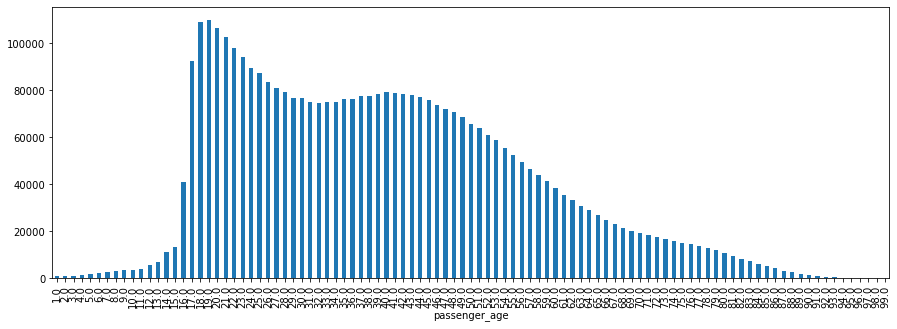

In [7]:
#passenger_age plot
plt.figure(figsize=(15,5))
pd.concat([df], axis=1).groupby(('passenger_age'))['fatality'].count().plot(kind="bar")

Encontramos algo curioso que no habíamos podido ver en el análisis descriptivo ya que vimos la distribución de edad con todos los pasajeros. Existen registros de conductores con una edad muy corta. ¡Tres, cuatro o cinco años! Outliers claramente erróneos que no deberíamos tener en cuenta.  
Acudiendo a la fuente oficial de los datos hemos encontrado la siguiente respuesta a la consulta de un usuario que confirma nuestras sospechas:  
*"The data in the NCDB are as reported by the provinces and territories. In some instances a child can be coded as being the driver when they are sitting on the lap of the real driver. In other cases, this would be an error, but there would be no way to determine which cases are the latter"*   
https://open.canada.ca/data/en/dataset/1eb9eba7-71d1-4b30-9fb1-30cbdab7e63a  
Con estos valores seguiremos la misma estrategia de imputación que empleemos con los missings.

<AxesSubplot:xlabel='vehicle_age'>

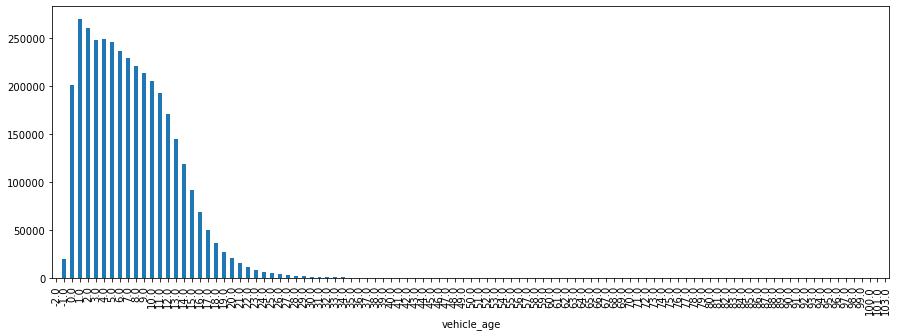

In [8]:
#vehicle_age plot
plt.figure(figsize=(15,5))
pd.concat([df], axis=1).groupby(('vehicle_age'))['fatality'].count().plot(kind="bar")

<AxesSubplot:xlabel='vehicles_involved'>

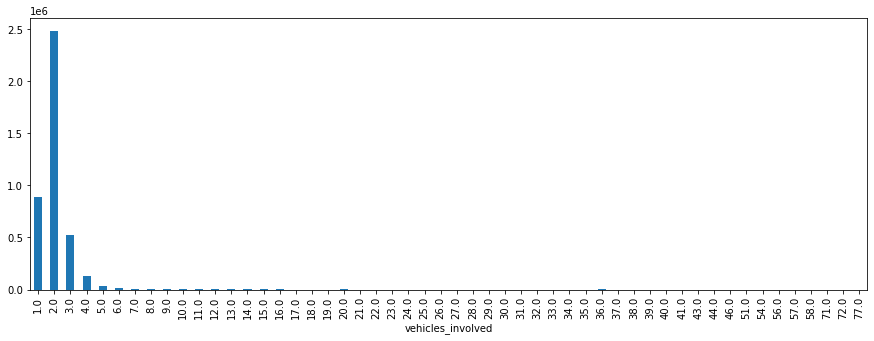

In [9]:
#passenger_age plot#passenger_age plot
plt.figure(figsize=(15,5))
pd.concat([df], axis=1).groupby(('vehicles_involved'))['fatality'].count().plot(kind="bar")


In [10]:
# Borramos filas con outliers 
df = df.loc[(df['vehicle_age'] < 30) | (df['vehicle_age'].isnull())]
df = df.loc[(df['vehicles_involved'] < 7)  | (df['vehicles_involved'].isnull())]

# Transformamos Outliers en nulos para imputar
df['passenger_age'][(df['passenger_age'] < 13)] = np.nan

### Tramificación Variable Temporales

Tramificamos las variables temporales antes de aplicar el encoding tal como explicamos en el EDA.

In [11]:
# Convertimos meses en cuatrimestres
df['month'] = (df['month']-1)//3 + 1
df = df.rename({'month': 'quarter'}, axis= 1)

In [12]:
# Reducimos weekday a tres tramos
df['weekday'] = df['weekday'].replace({6:3, 7:3, 1:2, 4:2, 5:2, 2:1, 3:1})

In [13]:
# Reducimos horas a seis tramos 
df['hour'] = df['hour'].replace({0:1, 1:1, 2:1, 3:1, 4:1, 5:1, 6:2, 7:2, 8:2, 9:3, 10:3, 11:3, 11:4, 12:4, 13:4, 14:4, 15:4, 16:4, 17:4, 18:4, 19:5, 20:5, 21:5, 22:6, 23:6})

## Pipeline

Creamos tres listas con las variables según el tratamiento que van a recibir:
- _few_cat_: Categóricas con 6 o menos categorías a las que aplicaremos One-Hot Encoding
- _many_cat_: Categóricas con 7 o más categorías a las que aplicaremos Mean Encoding
- _numeric_: Numéricas

In [31]:
# Categoricas pequeñas para OHE 
few_cat = []
for column in df.columns: 
    if (len(df[column].unique())< 7):
        few_cat.append(column)

if 'fatality' in few_cat: 
    few_cat.remove('fatality')

# Categoricas grandes para ME
many_cat = []
for column in df.columns[df.dtypes=='object']: 
    if (len(df[column].unique()) > 7):
        many_cat.append(column)

# numericas
numeric = ['vehicle_age', 'passenger_age', 'vehicles_involved', 'year']

time: 2.86 s (started: 2021-12-18 18:23:18 +01:00)



Creamos el pipeline de preprocesado que posteriormente aplicaremos de forma conjunta a los modelos.

In [19]:

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])


onehot_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value=np.nan)),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('target', TargetEncoder(handle_unknown='ignore'))])


preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric),
        ('fcat', onehot_transformer, few_cat),
        ('mcat', categorical_transformer, many_cat)])

# Guardamos el preprocessor
with open('../models/preprocessor.pickle', 'wb') as f:
    pickle.dump(preprocessor, f)

## Split en Train y Test

In [21]:
xtrain, xtest, ytrain, ytest = train_test_split(df.drop(columns=['fatality']), df['fatality'], test_size=0.20, random_state=0)
#xtrain = xtrain.drop(columns="index")
#xtest = xtest.drop(columns="index")

Comprobamos que Test y Train son similares

In [22]:
#Train
pd.concat([xtrain, pd.DataFrame(ytrain)]).describe().round(3)

,year,quarter,weekday,hour,vehicles_involved,vehicle_age,passenger_sex,passenger_age,fatality
count,3248945.000,3248945.000,3248945.000,3248945.000,3248945.000,2851519.000,3126745.000,3055919.000,3248945.000
mean,2006.014,2.568,1.944,3.697,2.007,7.412,0.618,39.673,0.015
std,4.569,1.113,0.729,1.152,0.767,5.283,0.486,16.586,0.122
min,1999.000,1.000,1.000,1.000,1.000,-2.000,0.000,13.000,0.000
25%,2002.000,2.000,1.000,3.000,2.000,3.000,0.000,25.000,0.000
50%,2006.000,3.000,2.000,4.000,2.000,7.000,1.000,38.000,0.000
75%,2010.000,4.000,2.000,4.000,2.000,11.000,1.000,51.000,0.000
max,2014.000,4.000,3.000,6.000,6.000,29.000,1.000,99.000,1.000


In [23]:
#Test
pd.concat([xtest, pd.DataFrame(ytest)]).describe().round(3)

,year,quarter,weekday,hour,vehicles_involved,vehicle_age,passenger_sex,passenger_age,fatality
count,812237.000,812237.000,812237.000,812237.000,812237.000,713158.000,781770.000,764314.000,812237.000
mean,2006.022,2.565,1.944,3.695,2.008,7.402,0.618,39.620,0.015
std,4.570,1.113,0.730,1.153,0.767,5.274,0.486,16.593,0.122
min,1999.000,1.000,1.000,1.000,1.000,-2.000,0.000,13.000,0.000
25%,2002.000,2.000,1.000,3.000,2.000,3.000,0.000,25.000,0.000
50%,2006.000,3.000,2.000,4.000,2.000,7.000,1.000,38.000,0.000
75%,2010.000,4.000,2.000,4.000,2.000,11.000,1.000,51.000,0.000
max,2014.000,4.000,3.000,6.000,6.000,29.000,1.000,99.000,1.000


## Selección de variables

Hemos decidido no emplear ninguna técnica de selección de variables. Esto se debe a que ya de por si tenemos un número reducido de variables y para la mayoría de nuestros modelos no supone ningún problema, más allá de un mayor coste computacional, la introducción de variables correlacionadas o con poco poder predictivo.  En los modelos que esto si puede suponer un problema, modelos de regresión, hemos optado por incluir regularización que ayuda a reducir la colinealidad entre variables predictoras.  

## Oversample (SMOTE)

Debido al desbalanceo tan grande presente en nuestros datos optamos también por hacer un Oversample de la clase minoritaria en el conjunto de entrenamiento. Comprobaremos en algunos modelos si esto mejora los resultados con respecto al dataset original. 

## Guardado de los datos

Guardamos los datos en formato _.parquet_ para introducir en los modelos.

In [25]:
xtrain.to_parquet("../data/xtrain.parquet")
xtest.to_parquet("../data/xtest.parquet")
pd.DataFrame(ytrain).to_parquet("../data/ytrain.parquet")
pd.DataFrame(ytest).to_parquet("../data/ytest.parquet")
#xtrain_smote.to_parquet("../data/xtrain_smote.parquet")
#pd.DataFrame(ytrain_smote).to_parquet("../data/ytrain_smote.parquet")